# Emukit tutorials on experimental design

## Load default libraries

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
# set up plotting settings for dark mode.
from jupyterthemes import jtplot
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)
from src.plot_utils import ps_defaults
ps_defaults(use_tex=False, dpi=150)
import matplotlib.pyplot as plt

## Make a Latin Hypercuber

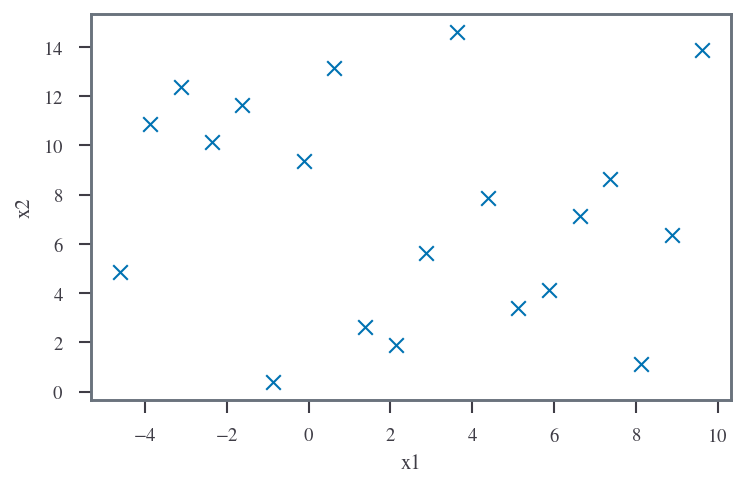

In [3]:
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = ParameterSpace(
    [ContinuousParameter("x1", -5, 10), ContinuousParameter("x2", 0, 15)]
)
design = LatinDesign(parameter_space) 
num_data_points = 20
X = design.get_samples(num_data_points)

plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Sobol Sequence equivalent

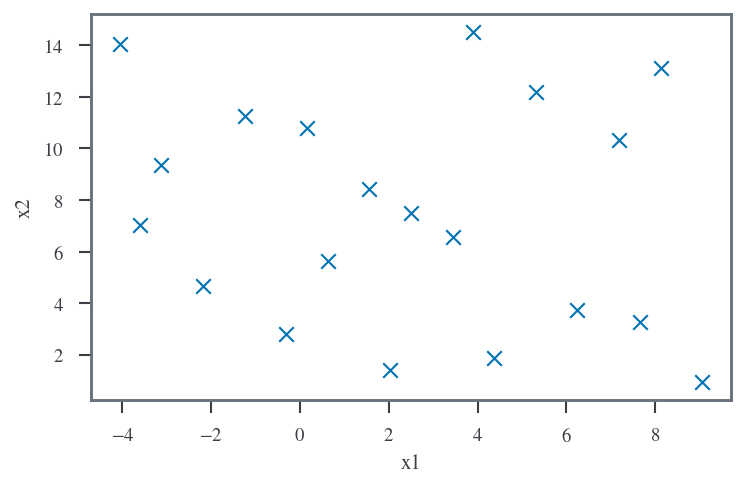

In [4]:
from emukit.core.initial_designs.sobol_design import SobolDesign

design = SobolDesign(parameter_space) 
X1 = design.get_samples(num_data_points)
plt.scatter(X1[:, 0], X1[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Emukit test function

In [5]:
from emukit.test_functions import branin_function

f, _ = branin_function()

## Model selected data points as a Gaussian Process

In [6]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

Y = f(X)
model_gpy = GPRegression(X, Y)
model_emukit = GPyModelWrapper(model_gpy)

## Look at Gaussian Process variance

In [7]:
from emukit.experimental_design.acquisitions import ModelVariance

model_variance = ModelVariance(model=model_emukit)

Text(0, 0.5, 'cov')

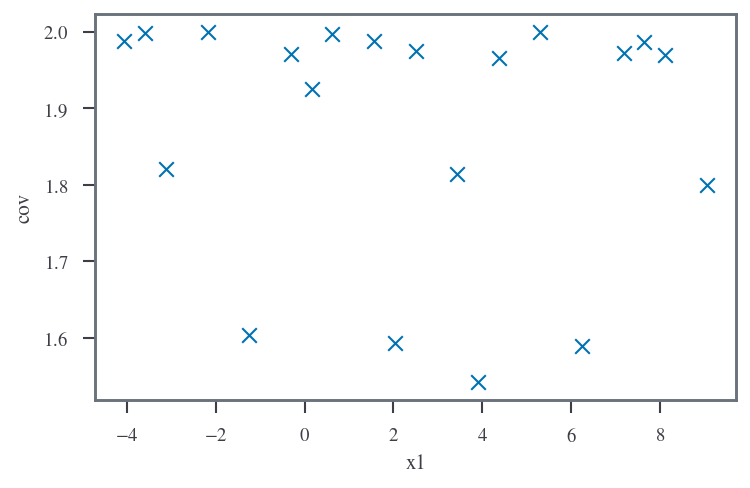

In [8]:
x = X1[:, 0]
_, y_cov = model_variance.model.predict(X1)
plt.scatter(X1[:, 0], y_cov, marker="x")
plt.xlabel("x1")
plt.ylabel("cov")

## Set-up experimental design loop

In [9]:
from emukit.experimental_design import ExperimentalDesignLoop

expdesign_loop = ExperimentalDesignLoop(
    model=model_emukit, space=parameter_space, acquisition=model_variance, batch_size=5
)

##  ML in the Physical world example

In [12]:
import numpy as np
import GPy
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper

In [13]:
x_min = -30.0
x_max = 30.0

x_data = np.random.uniform(x_min, x_max, (10, 1))
y_data = np.sin(x_data) + np.random.randn(10, 1) * 0.05

In [14]:
emukit_model = SimpleGaussianProcessModel(x_data, y_data)

In [15]:
p = ContinuousParameter('c', x_min, x_max)
space = ParameterSpace([p])

In [16]:
loop = ExperimentalDesignLoop(space, emukit_model)
loop.run_loop(np.sin, 30)
plot_min = -40.0
plot_max = 40.0
real_x = np.arange(plot_min, plot_max, 0.2)
real_y = np.sin(real_x)

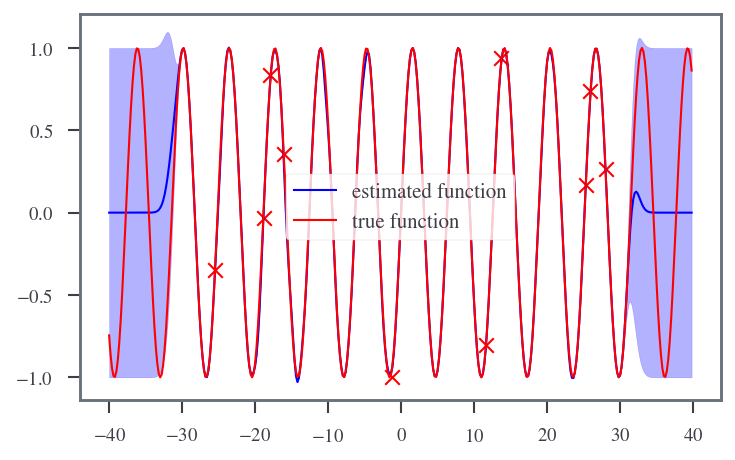

In [27]:
loop = ExperimentalDesignLoop(space, emukit_model)
loop.run_loop(np.sin, 30)
plot_min = -40.0
plot_max = 40.0
real_x = np.arange(plot_min, plot_max, 0.2)
real_y = np.sin(real_x)
predicted_y = []
predicted_std = []
for x in real_x:
    y, var = emukit_model.predict(np.array([[x]]))
    std = np.sqrt(var)
    predicted_y.append(y)
    predicted_std.append(std)

predicted_y = np.array(predicted_y).flatten()
predicted_std = np.array(predicted_std).flatten()
plt.plot(real_x, predicted_y, label="estimated function", color="blue")
plt.fill_between(
    real_x,
    predicted_y - predicted_std,
    predicted_y + predicted_std,
    color="blue",
    alpha=0.3,
)
plt.scatter(x_data, y_data, c="red")
plt.plot(real_x, real_y, label="true function", color="red")
plt.legend()

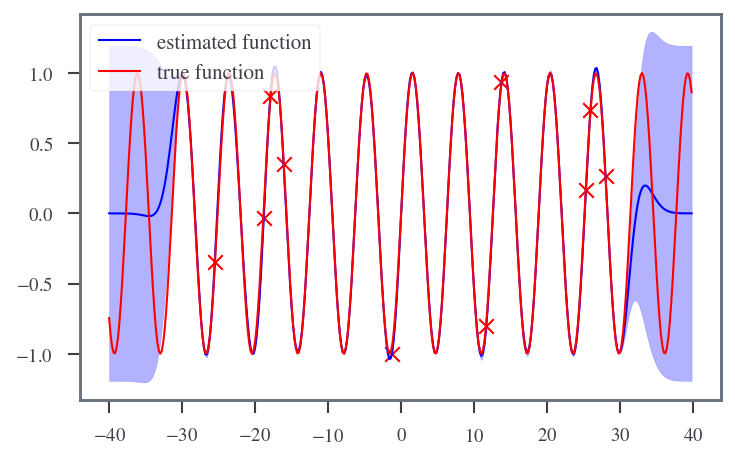

## Scikit-learn GP wrapping

In [19]:
import numpy as np
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper
from sklearn.gaussian_process import GaussianProcessRegressor

In [20]:
!pip install sklearn

In [21]:
x_min = -30.0
x_max = 30.0

X = np.random.uniform(x_min, x_max, (10, 1))
Y = np.sin(X) + np.random.randn(10, 1) * 0.05
sklearn_gp = GaussianProcessRegressor();
sklearn_gp.fit(X, Y);

In [22]:
from emukit.core.interfaces import IModel

class SklearnGPModel(IModel):
    def __init__(self, sklearn_model):
        self.model = sklearn_model

    def predict(self, X):
        mean, std = self.model.predict(X, return_std=True)
        return mean[:, None], np.square(std)[:, None]

    def set_data(self, X: np.ndarray, Y: np.ndarray) -> None:
        self.model.fit(X, Y)

    def optimize(self, verbose: bool = False) -> None:
        # There is no separate optimization routine for sklearn models
        pass
    
    @property
    def X(self) -> np.ndarray:
        return self.model.X_train_
    
    @property
    def Y(self) -> np.ndarray:
        return self.model.y_train_

emukit_model = SklearnGPModel(sklearn_gp)

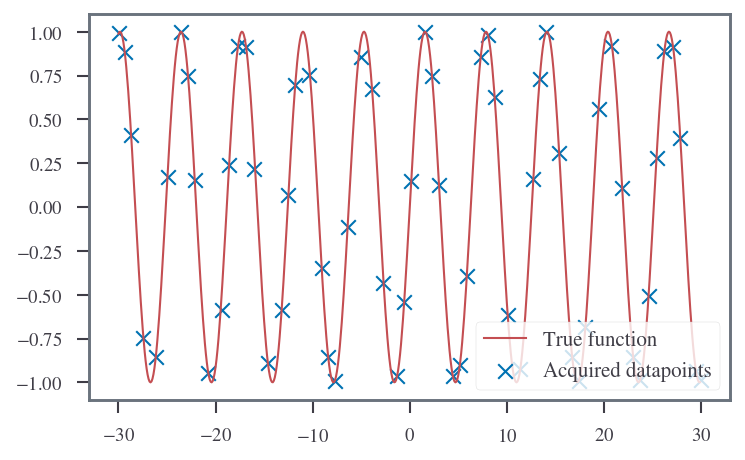

In [23]:
p = ContinuousParameter("c", x_min, x_max)
space = ParameterSpace([p])

loop = ExperimentalDesignLoop(space, emukit_model)
loop.run_loop(np.sin, 50)
real_x = np.arange(x_min, x_max, 0.1)
real_y = np.sin(real_x)

plt.plot(real_x, real_y, c="r")
plt.scatter(loop.loop_state.X[:, 0].tolist(), loop.loop_state.Y[:, 0].tolist())
plt.legend(["True function", "Acquired datapoints"], loc="lower right")

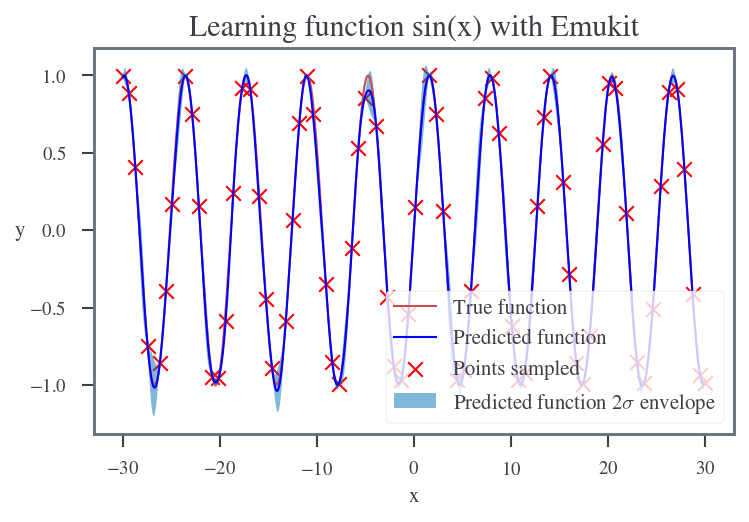

In [24]:
p = ContinuousParameter("c", x_min, x_max)
space = ParameterSpace([p])

loop = ExperimentalDesignLoop(space, emukit_model)
loop.run_loop(np.sin, 10)

real_x = np.arange(x_min, x_max, 0.1)
real_y = np.sin(real_x)

predicted_y = []
predicted_std = []

for x in real_x:
    y, var = emukit_model.predict(np.array([[x]]))
    std = np.sqrt(var)
    predicted_y.append(y)
    predicted_std.append(std)

predicted_y = np.array(predicted_y).flatten()
predicted_std = np.array(predicted_std).flatten()

plt.title("Learning function sin(x) with Emukit")
plt.xlabel("x")
plt.ylabel("y", rotation=None)

plt.plot(real_x, real_y, c="r", label="True function")
plt.plot(real_x, predicted_y, color="blue", label="Predicted function")

plt.scatter(
    loop.loop_state.X[:, 0].tolist(),
    loop.loop_state.Y[:, 0].tolist(),
    color="red",
    label="Points sampled",
)

plt.fill_between(
    real_x, predicted_y - 2 * predicted_std, predicted_y + 2 * predicted_std, alpha=0.5, label="Predicted function 2$\sigma$ envelope"
)
plt.legend(loc="lower right")